In [1]:
from datasets import load_dataset, DatasetDict, concatenate_datasets, Dataset
from IPython.display import display
import torchaudio
import datasets
import pandas as pd
import os
import re
import numpy as np
import gc
import soundfile as sf
import IPython
import torch
from tqdm import tqdm

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
dataset = load_dataset("oza75/bambara-tts", "denoised")
dataset['train'] = dataset['train'].add_column('lang', ['bm'] * len(dataset['train'])).rename_column("bambara", "text")
dataset

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'french', 'duration', 'speaker_embeddings', 'speaker_id', 'lang'],
        num_rows: 30765
    })
})

In [3]:
CHAR_LIMIT = {
    "en": 250,
    "fr": 273,
    "es": 239,
    "it": 213,
    "bm": 230,
}
non_valid_speakers = [26, 2, 6, 0, 1, 20]

def is_valid_items(batch, idxs):
    # This will be a list of booleans indicating whether each example is valid
    validity_mask = [
        ((speaker_id == 26 and 2900 < idx < 3600) or speaker_id not in non_valid_speakers) and len(text) <= CHAR_LIMIT[lang]
        for speaker_id, text, lang, idx in zip(batch['speaker_id'], batch['text'], batch['lang'], idxs)
    ]
    return validity_mask

def iterable_to_dataset(iterable_dataset, lang, num_rows):
    """
    Converts an IterableDataset to a Dataset with a specified number of rows using a while loop.

    Parameters:
    - iterable_dataset (IterableDataset): The input IterableDataset from Hugging Face datasets.
    - num_rows (int): The number of rows desired in the output Dataset.

    Returns:
    - Dataset: A Dataset object with the specified number of rows.
    """
    # Create an iterator from the iterable dataset
    iterator = iter(iterable_dataset)

    # Initialize an empty list to store the dataset rows
    rows = []

    # Initialize the tqdm progress bar
    progress_bar = tqdm(total=num_rows, desc='Converting', unit='row')

    try:
        # Collect the specified number of rows
        while len(rows) < num_rows:
            item = next(iterator)
            if len(item['text']) <= CHAR_LIMIT[lang]:
                item["lang"] = lang
                rows.append(item)
                progress_bar.update(1)
    except StopIteration:
        # End of iterator reached
        print("End of iterable dataset reached before requested number of rows.")
    finally:
        progress_bar.close()

    # Convert the list of rows to a Dataset object
    converted_dataset = Dataset.from_pandas(pd.DataFrame(rows))

    return converted_dataset

In [4]:
filtered_ds = dataset['train'].filter(is_valid_items, batched=True, with_indices=True)
filtered_ds

Filter:   0%|          | 0/30765 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'text', 'french', 'duration', 'speaker_embeddings', 'speaker_id', 'lang'],
    num_rows: 100
})

In [5]:
np.unique(filtered_ds['lang'], return_counts=True)

(array(['bm'], dtype='<U2'), array([100]))

In [6]:
def create_audio_file(example, audio_column, output_dir, index):
    """
    Creates a single audio file from the 'audio' column of an example and returns the file path.
    """
    # Construct the output file path
    audio_filename = f"audio_{index}.wav"
    audio_filepath = os.path.join(output_dir, audio_filename)

    # If file does not exist, write the audio data to the file
    if not os.path.isfile(audio_filepath):
        # Extract audio data and sample rate from the example
        audio_data = example[audio_column]['array']
        sample_rate = example[audio_column]['sampling_rate']

        # Save the audio file
        sf.write(audio_filepath, audio_data, sample_rate)

    return {"audio_file_path": audio_filepath}


def batch_create_audio_files_and_update_dataset(dataset, audio_column, output_dir):
    """
    Maps over the dataset, creates audio files and updates the dataset with the file paths.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Use the .map() function to process the dataset and create audio files
    dataset_with_audio_paths = dataset.map(
        lambda example, idx: create_audio_file(example, audio_column, output_dir, idx),
        with_indices=True,  # Pass example indices to the map function
        num_proc=12
    )

    return dataset_with_audio_paths


def create_audio_files_and_update_dataset(dataset, audio_column, output_dir):
    """
    Create audio files from the 'audio' column of a Hugging Face dataset and update the dataset with file paths.

    Parameters:
    - dataset: The input dataset that contains the 'audio' column.
    - audio_column: The name of the column containing the audio data (datasets.Audio feature).
    - output_dir: The directory where audio files will be saved.

    Returns:
    - The updated dataset with the 'audio' column containing the file paths of saved audio files.
    """
    # Make sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Prepare a list to hold the file paths, to avoid modifying the dataset in-place
    audio_file_paths = []

    for index, example in tqdm(enumerate(dataset), total=len(dataset), desc="Creating audio files", unit="file"):
        audio_filename = f"audio_{index}.wav"
        audio_filepath = os.path.join(output_dir, audio_filename)

        if os.path.isfile(audio_filepath):
            audio_file_paths.append(audio_filepath)
            continue

        audio_data = example[audio_column]['array']
        # Typically, the sample rate should also be retrieved from the dataset
        sample_rate = example[audio_column]['sampling_rate']

        # Save the audio file
        sf.write(audio_filepath, audio_data, sample_rate)

        # Append the file path to the list
        audio_file_paths.append(audio_filepath)

        # Option to clear memory if needed, uncomment if large arrays are involved
        del audio_data
        gc.collect()

    # Update the dataset with the new file paths
    dataset = dataset.add_column("audio_file_path", audio_file_paths)

    return dataset


# Function to create the metadata file
def create_metadata_file(dataset, output_dir='MyTTSDataSet', filename='metadata.txt'):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define the path to the metadata file
    metadata_path = os.path.join(output_dir, filename)

    # Open the metadata file in write mode
    with open(metadata_path, 'w', encoding='utf-8') as f:
        # Iterate over each item in the dataset
        for item in dataset:
            # Your dataset should have an 'audio' column with a dictionary containing the file path and 'array' for the audio data
            audio_path = item['audio_file_path'].replace(".wav", "")
            text = item['text'].replace(" ", " ").replace(" ", " ").replace("\n", " ")
            normalized_text = text
            speaker_id = item['speaker_id']
            lang = item['lang']

            # Write the formatted data to the metadata file
            f.write(f"{audio_path}|{text}|{normalized_text}|{speaker_id}|{lang}\n")

    return metadata_path

In [7]:
filtered_ds = batch_create_audio_files_and_update_dataset(
    filtered_ds,
    audio_column="audio",
    output_dir="/workspace/coqui-TTS/finetuning/bambara/dataset/audios/"
)
filtered_ds

Map (num_proc=12):   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'text', 'french', 'duration', 'speaker_embeddings', 'speaker_id', 'lang', 'audio_file_path'],
    num_rows: 100
})

In [8]:
filtered_ds_dict = filtered_ds.train_test_split(test_size=0.1, seed=42)
filtered_ds_dict

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'french', 'duration', 'speaker_embeddings', 'speaker_id', 'lang', 'audio_file_path'],
        num_rows: 90
    })
    test: Dataset({
        features: ['audio', 'text', 'french', 'duration', 'speaker_embeddings', 'speaker_id', 'lang', 'audio_file_path'],
        num_rows: 10
    })
})

In [9]:
create_metadata_file(filtered_ds_dict['train'], output_dir="./dataset")
create_metadata_file(filtered_ds_dict['test'], output_dir="./dataset", filename='metadata_val.txt')

'./dataset/metadata_val.txt'

In [ ]:
! CUDA_VISIBLE_DEVICES="0" python ./train_gpt_xtts_2.py

In [5]:
print("> Loading the data using streaming mode....")
mls_fr = load_dataset("ylacombe/cml-tts", "french", split="train", streaming=True)
mls_es = load_dataset("ylacombe/cml-tts", "spanish", split="train", streaming=True)
mls_it = load_dataset("ylacombe/cml-tts", "italian", split="train", streaming=True)
lj_en = load_dataset("lj_speech", split="train", streaming=True)

> Loading the data using streaming mode....


Resolving data files:   0%|          | 0/373 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/130 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/373 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/203 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/373 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/61 [00:00<?, ?it/s]

In [6]:
MULTI_LANG_SIZE = 50
print("> Building datasets....")
fr_ds = iterable_to_dataset(mls_fr, "fr", MULTI_LANG_SIZE)
es_ds = iterable_to_dataset(mls_es, "es", MULTI_LANG_SIZE)
it_ds = iterable_to_dataset(mls_it,"it", MULTI_LANG_SIZE)
en_ds = iterable_to_dataset(lj_en, "en", MULTI_LANG_SIZE).add_column("speaker_id", ['ljspeech'] * MULTI_LANG_SIZE)
print("> Selecting columns....")
fr_ds = fr_ds.select_columns(['audio', 'text', 'lang', 'speaker_id'])
es_ds = es_ds.select_columns(['audio', 'text', 'lang', 'speaker_id'])
it_ds = it_ds.select_columns(['audio', 'text', 'lang', 'speaker_id'])
en_ds = en_ds.select_columns(['audio', 'text', 'lang', 'speaker_id'])
print("> Casting the columns...")
en_ds = en_ds.cast_column('audio', datasets.Audio(sampling_rate=22050))
fr_ds = fr_ds.cast(en_ds.features.copy())
es_ds = es_ds.cast(en_ds.features.copy())
it_ds = it_ds.cast(en_ds.features.copy())

> Building datasets....


Converting: 100%|██████████| 50/50 [00:01<00:00, 25.18row/s]


> Selecting columns....
> Casting the columns...


Casting the dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

In [7]:
def assign_integer_ids_to_speakers(dataset):
    """
    Assigns an integer ID to each unique speaker UUID in the 'instance' column of the dataset.

    Parameters:
    - dataset: The input dataset loaded using the Hugging Face `datasets` library.

    Returns:
    - The dataset with an additional column 'speaker_id' containing integer IDs for each speaker.
    """
    # Step 1: Extract all unique instances (speaker UUIDs) in a memory-efficient way
    unique_instances = set(dataset['speaker_id'])

    # Step 2: Create a mapping from UUIDs to integer IDs
    instance_to_id = {uuid: idx for idx, uuid in enumerate(unique_instances)}

    # Step 3: Apply the mapping to create a 'speaker_id' column, in batches
    def add_speaker_id(examples):
        # Map each instance (UUID) in the batch to its corresponding integer ID
        examples['speaker_id'] = [instance_to_id[instance] + 28 for instance in examples['speaker_id']]
        return examples

    # Apply the function in a batched manner
    dataset = dataset.map(add_speaker_id, batched=True, batch_size=10000)

    return dataset

In [34]:
multi_ds = concatenate_datasets([en_ds, fr_ds, es_ds, it_ds])
multi_ds = assign_integer_ids_to_speakers(multi_ds)
multi_ds = multi_ds.cast_column('speaker_id', datasets.Value(dtype='int32'))
multi_ds

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'text', 'lang', 'speaker_id'],
    num_rows: 200
})

In [35]:
bam_ds = (
    dataset['train']
    .select_columns(['audio', 'bambara', 'speaker_id'])
    .rename_column('bambara', 'text')
    .add_column('lang', ['bm'] * len(dataset['train']))
)
bam_ds.cast(multi_ds.features.copy())
bam_ds

Dataset({
    features: ['audio', 'text', 'speaker_id', 'lang'],
    num_rows: 4430
})

In [62]:
tts_ds = concatenate_datasets([multi_ds, bam_ds]).shuffle()
tts_ds

Dataset({
    features: ['audio', 'text', 'lang', 'speaker_id'],
    num_rows: 4630
})

In [169]:
filtered_ds = tts_ds.filter(is_valid_items, batched=True)
filtered_ds

Filter:   0%|          | 0/6430 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'text', 'lang', 'speaker_id'],
    num_rows: 5727
})

In [8]:
def resample_audio_to_2d(audio, orig_sr, target_sr):
    """
    Resample an audio sample to a specified target sampling rate and ensure it is two-dimensional.

    Parameters:
    - audio (Tensor or numpy.ndarray): The original audio data.
    - orig_sr (int): The original sampling rate of the audio data.
    - target_sr (int): The target sampling rate to resample the audio data to.

    Returns:
    - Tensor: A two-dimensional tensor representing the resampled audio.
    """
    # Ensure the audio is a tensor
    if not isinstance(audio, torch.Tensor):
        audio = torch.tensor(audio, dtype=torch.float32)

    # Add a channel dimension if the audio is 1D
    if audio.ndim == 1:
        audio = audio.unsqueeze(0)

    # Resample the audio if the sampling rates are different
    if orig_sr != target_sr:
        # Create the resample transformation
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=target_sr)
        audio = audio.mean(dim=0, keepdim=True)
        # Resample audio
        audio = resampler(audio)

    return audio

In [12]:
# speech_enhancement_model = separator.from_hparams(
#     source="speechbrain/sepformer-whamr-enhancement",
#     savedir='pretrained_models/sepformer-whamr-enhancement'
# )
speech_enhancement_model = separator.from_hparams(
    source="speechbrain/sepformer-dns4-16k-enhancement",
    savedir='pretrained_models/sepformer-dns4-16k-enhancement'
)


def speech_enhancement(item):
    sample_rate = speech_enhancement_model.hparams.sample_rate
    audio = resample_audio_to_2d(item['audio']['array'], item['audio']['sampling_rate'], sample_rate)
    ouputs = speech_enhancement_model.separate_batch(audio)
    item['audio']['array'] = ouputs[:, :, 0].detach().cpu()
    item['audio']['sampling_rate'] = sample_rate

    return item

hyperparams.yaml:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

encoder.ckpt:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

masknet.ckpt:   0%|          | 0.00/113M [00:00<?, ?B/s]

decoder.ckpt:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

In [13]:
def test_speech_enhancement(item):
    display(IPython.display.Audio(item['audio']['array'], rate=item['audio']['sampling_rate']))
    enhanced = speech_enhancement(item)
    display(IPython.display.Audio(enhanced['audio']['array'], rate=enhanced['audio']['sampling_rate']))

In [54]:
test_speech_enhancement(es_ds[1])

In [37]:
torchaudio.save('./bam_noisy_audio.wav',
                resample_audio_to_2d(bam_ds[4]['audio']['array'], bam_ds[4]['audio']['sampling_rate'],
                                     bam_ds[4]['audio']['sampling_rate']), bam_ds[4]['audio']['sampling_rate'])

In [ ]:
from resemble_enhance.enhancer.inference import denoise, enhance

In [292]:
import librosa
from matplotlib import pyplot as plt
import random
import speechmetrics

window_length = 1  # seconds
metrics = speechmetrics.load('absolute.srmr', window_length)


def calculate_srmr(audio):
    """
    Calculate the SRMR of an audio signal.

    Parameters:
    - audio: Audio signal as a numpy array.
    - sr: Sampling rate of the audio signal.
    - frame_length: Length of each frame to analyze.
    - hop_length: Number of samples to shift for the next frame.

    Returns:
    - srmr: SRMR of the audio signal.
    """
    scores = metrics(
        resample_audio_to_2d(audio['array'], audio['sampling_rate'], 16000)[0, :].numpy(),
        rate=16000
    )
    return scores['srmr'].mean()


def calculate_zcr(audio, frame_length=2048, hop_length=512):
    """
    Calculate the Zero Crossing Rate of an audio signal.

    Parameters:
    - audio: Audio signal as a numpy array.
    - sr: Sampling rate of the audio signal.
    - frame_length: Length of each frame to analyze.
    - hop_length: Number of samples to shift for the next frame.

    Returns:
    - zcr: Zero Crossing Rate of the audio signal.
    """
    # Calculate ZCR
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length)
    # The function returns an array [zcr] for each frame, so we can return the mean
    return np.mean(zcr)


def calculate_rms(audio, frame_length=2048, hop_length=512):
    """
    Calculate the Root Mean Square energy of an audio signal.

    Parameters:
    - audio: Audio signal as a numpy array.
    - frame_length: Length of each frame to analyze.
    - hop_length: Number of samples to shift for the next frame.

    Returns:
    - rms: Root Mean Square energy of the audio signal.
    """
    # Compute the Short-Time Fourier Transform (STFT) of the audio
    S = np.abs(librosa.stft(audio, n_fft=512))
    
    # Calculate RMS energy
    rms = librosa.feature.rms(S=S, frame_length=frame_length)
    # The function returns an array [rms] for each frame, so we can return the mean
    return np.mean(rms)


def calculate_loudness_variability(audio, frame_length=2048):
    """
    Calculate the loudness variability of an audio signal based on RMS energy.

    Parameters:
    - audio: Audio signal as a numpy array.
    - frame_length: Length of each frame to analyze for RMS calculation.
    - hop_length: Number of samples to shift for the next frame of RMS calculation.

    Returns:
    - loudness_variability: Standard deviation of the RMS values across the audio frames, representing loudness variability.
    """
    # Calculate RMS energy
    rms = librosa.feature.rms(y=audio, frame_length=frame_length)

    # Calculate the standard deviation of the RMS values
    loudness_variability = np.std(rms)

    return loudness_variability


def calculate_normalized_spectral_contrast(audio, sr, n_fft=2048, hop_length=512):
    """
    Calculate the normalized spectral contrast of an audio signal.

    Parameters:
    - audio: Audio signal as a numpy array.
    - sr: Sampling rate of the audio signal.
    - n_fft: Number of FFT components.
    - hop_length: Number of samples to shift for the next frame.

    Returns:
    - normalized_spectral_contrast: Normalized spectral contrast of the audio signal.
    """
    # Compute the Short-Time Fourier Transform (STFT) of the audio
    S = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))

    # Calculate spectral contrast
    spectral_contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

    # Compute the average spectral contrast
    avg_spectral_contrast = np.mean(spectral_contrast)

    # Find the maximum spectral contrast to use for normalization
    max_spectral_contrast = np.max(spectral_contrast)

    # Normalize spectral contrast: we subtract from 1 to reverse the scale so that higher values are better
    normalized_spectral_contrast = 1 - (avg_spectral_contrast / max_spectral_contrast)

    return normalized_spectral_contrast


Loaded  speechmetrics.absolute.srmr


In [299]:
def process_and_plot_dataset(dataset, audio_column='audio'):
    """
    Compute ZCR and RMS for each audio file in a dataset, add them as columns, and plot histograms.
    
    Parameters:
    - dataset: The Hugging Face dataset containing the audio files.
    - audio_column: The name of the column containing the audio data.
    
    Returns:
    - Dataset: The updated dataset with ZCR and RMS columns.
    """
    frame_length = 512
    hop_length = frame_length // 4
    
    def compute_features(examples):
        """Compute ZCR and RMS for a single audio example."""
        avg_zcr, loudness_variability, spectral_contrast, scores = [], [], [], []
        for idx in range(len(examples[audio_column])):
            audio = examples[audio_column][idx]
            audio['array'] = librosa.util.normalize(audio['array'])
            item_std_rms = calculate_loudness_variability(audio['array'], frame_length=441)
            item_avg_zcr = calculate_zcr(audio['array'], frame_length=221)
            item_spectral_contrast = calculate_normalized_spectral_contrast(audio['array'], audio['sampling_rate'], n_fft=512)
            item_score = (
                    (1 - item_std_rms) * 0.1 +
                    (1 - item_avg_zcr) * 0.3 +
                    (item_spectral_contrast * 0.6)
            )

            loudness_variability.append(1 - item_std_rms)
            avg_zcr.append(1 - item_avg_zcr)
            spectral_contrast.append(item_spectral_contrast)
            scores.append(item_score)

        examples['zcr'] = avg_zcr
        examples['lv'] = loudness_variability
        examples['spc'] = spectral_contrast
        examples['score'] = scores

        return examples

    # Apply the compute_features function to each example in the dataset
    dataset = dataset.map(compute_features, batched=True)

    # Plot histograms
    zcr_values = dataset['zcr']
    loudness_variability_values = dataset['lv']
    spc_values = dataset['spc']
    score_values = dataset['score']

    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    plt.hist(zcr_values, bins=30, color='blue', edgecolor='black')
    plt.title('Histogram of ZCR')

    plt.subplot(1, 4, 2)
    plt.hist(loudness_variability_values, bins=30, color='green', edgecolor='black')
    plt.title('Histogram of Loudness Variability')

    plt.subplot(1, 4, 3)
    plt.hist(spc_values, bins=30, color='yellow', edgecolor='black')
    plt.title('Histogram of Spectral Contrast')

    plt.subplot(1, 4, 4)
    plt.hist(score_values, bins=30, color='orange', edgecolor='black')
    plt.title('Histogram of Audio Quality Score')

    plt.show()

    return dataset


def display_random_audio(dataset, num_items=5, audio_column='audio'):
    """
    Display audio players for random audio files from a Hugging Face dataset.

    Parameters:
    - dataset: The Hugging Face dataset containing the audio files.
    - audio_column: The name of the column containing the audio data (should contain a dictionary with 'array' and 'sampling_rate').
    - num_items: The number of random audio files to display.
    """
    # Randomly select a number of items from the dataset
    random_indices = random.sample(range(0, len(dataset)), num_items)

    for index in random_indices:
        # Retrieve the audio data and sampling rate
        audio_data = dataset[index][audio_column]['array']
        sampling_rate = dataset[index][audio_column]['sampling_rate']

        # Display the audio player
        print(f"[{dataset[index]['lang']}] {dataset[index]['text']}")
        display(IPython.display.Audio(audio_data, rate=sampling_rate))

Map:   0%|          | 0/4430 [00:00<?, ? examples/s]

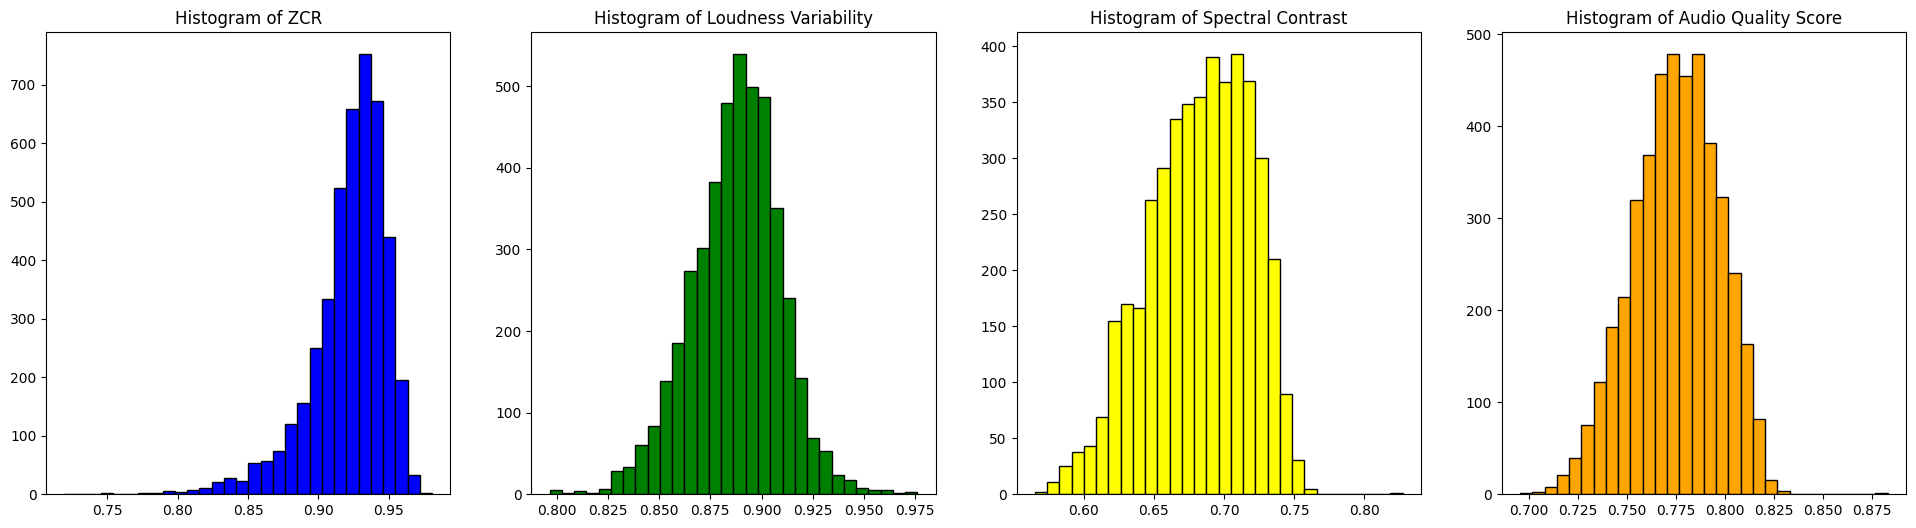

Dataset({
    features: ['audio', 'text', 'speaker_id', 'lang', 'zcr', 'lv', 'spc', 'score'],
    num_rows: 4430
})

In [303]:
noise_ds = process_and_plot_dataset(bam_ds)
noise_ds

In [311]:
filtered_noise_ds = noise_ds.filter(
    lambda ex: [zcr <= 0.83  for zcr, lv, spc, score, audio in zip(ex['zcr'], ex['lv'], ex['spc'], ex['score'], ex['audio'])],
    batched=True,
    batch_size=10000
)

display_random_audio(filtered_noise_ds, num_items=min(filtered_noise_ds.shape[0], 5))

Filter:   0%|          | 0/4430 [00:00<?, ? examples/s]

[bm] Ne tatiɲɛna sa !


[bm] Ko nka mɔgɔ si de ma faga o mugufiliw senfɛ.


[bm] Ɲɔw falenna koɲuman.


[bm] U y'u dege u ka ko la, fo k'u se kosɛbɛ.


[bm] Dugukolo tɛ mɔgɔ nɛgɛn, a tɛ mɔgɔ janfa.


In [297]:
filtered_noise_ds[:]

{'audio': [{'path': None,
   'array': array([ 0.00109863,  0.00164795,  0.00183105, ..., -0.00067139,
          -0.00054932,  0.        ]),
   'sampling_rate': 22050},
  {'path': None,
   'array': array([0.00030518, 0.00064087, 0.        , ..., 0.00012207, 0.00015259,
          0.00024414]),
   'sampling_rate': 22050},
  {'path': None,
   'array': array([0.00048828, 0.0010376 , 0.00091553, ..., 0.00283813, 0.00250244,
          0.00228882]),
   'sampling_rate': 22050},
  {'path': None,
   'array': array([-0.00042725, -0.00042725, -0.00048828, ...,  0.00048828,
           0.00057983,  0.        ]),
   'sampling_rate': 22050},
  {'path': None,
   'array': array([0.00054932, 0.00128174, 0.00140381, ..., 0.00167847, 0.00082397,
          0.00048828]),
   'sampling_rate': 22050},
  {'path': None,
   'array': array([0.03115845, 0.03735352, 0.03485107, ..., 0.04724121, 0.04217529,
          0.00567627]),
   'sampling_rate': 22050},
  {'path': None,
   'array': array([-0.0020752 , -0.00244141,

In [191]:
2048 // 4

512

In [128]:
import speechmetrics

window_length = 1  # seconds
metrics = speechmetrics.load('absolute.srmr', window_length)
scores = metrics(
    resample_audio_to_2d(es_ds['audio'][:10]['array'], es_ds[1]['audio']['sampling_rate'], 16000)[0, :].numpy(),
    rate=16000
)
scores['srmr'].mean()

Loaded  speechmetrics.absolute.srmr


5.972361950273594

In [114]:
resample_audio_to_2d(es_ds[1]['audio']['array'], es_ds[1]['audio']['sampling_rate'], 16000)[0, :].shape

torch.Size([214241])

In [144]:
def evaluate_audio_quality(item):
    audio, sr = item['array'], item['sampling_rate']
    # Normalize audio
    audio = librosa.util.normalize(audio)

    # Compute loudness variability
    rms = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)
    loudness_variability = np.std(rms)

    # Compute Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=2048, hop_length=512)
    avg_zcr = np.mean(zcr)

    # Compute Spectral Contrast
    S = np.abs(librosa.stft(audio))
    spectral_contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
    avg_spectral_contrast = np.mean(spectral_contrast)

    # Normalize spectral contrast for better integration
    normalized_spectral_contrast = 1 - (avg_spectral_contrast / np.max(spectral_contrast))

    # Combine metrics into a score: Example of a simple average
    # Adjust weights as needed
    # Here, we assume less variability, lower ZCR, and lower spectral contrast indicate better quality
    print("> loudness variability: ", loudness_variability)
    print("> zcr: ", avg_zcr)
    print("> spectral contrast: ", normalized_spectral_contrast)

    score = ((1 - loudness_variability) * 0.3 +
             (1 - avg_zcr) * 0.3 +
             normalized_spectral_contrast * 0.4)

    return score

In [159]:
def manual_audio_quality_check(item):
    display(IPython.display.Audio(item['array'], rate=item['sampling_rate']))
    return evaluate_audio_quality(item)


manual_audio_quality_check(es_ds[10]['audio'])

> loudness variability:  0.07059418
> zcr:  0.07689591036498092
> spectral contrast:  0.6451501840545202


0.8138130475172995

In [160]:
manual_audio_quality_check(es_ds[1]['audio'])

> loudness variability:  0.05940384
> zcr:  0.15849761698440207
> spectral contrast:  0.5917585230600291


0.7713329719929612